# Homework 5
### Dimensionality Reduction and Clustering
##### Erik Webb

Hello! In this assignment we'll be working with the MNIST dataset, which is a large collection of handwritten digits. Luckily for us, each of the digits have been 'size-normalized' and centered, minimizing the need for preprocessing and formatting. 

Here's an image from [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database) to give an idea of what we're working with.

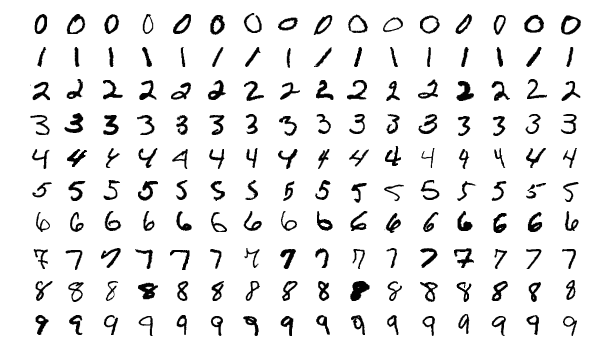

In [1]:
# Source: https://en.wikipedia.org/wiki/MNIST_database
from IPython.display import Image 
Image('https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png')

Like usual, we'll get started by calling in the required modules and bringing in the data.

In [2]:
# Core Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
%matplotlib inline

# ML Packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from numpy import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.utils import shuffle

# Other Packages
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings('ignore')

In [51]:
from sklearn.datasets import fetch_mldata

# Bring in the data
mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

Each observation in this dataset is a 28 x 28 pixel image, meaning each image contains 784 (28 x 28) pixels. Each of the 784 pixels has a value associated with it which indicates the lightness or darkness of that pixel. Theses values range from 0 to 255. [Source](https://www.kaggle.com/c/digit-recognizer/data)

In [4]:
# Confirm the dimensions of the data
X.shape

(70000, 784)

As you can imagine, it's pretty difficult to visualize anything in 784 dimensions. Our first task will be to reduce the high dimensionality of this data using PCA.

### 1. Use PCA to reduce the dimensionality

#### a. How many components did you use? Why?

We know that we want to reduce the dimensionality of our data by breaking it into components, but how many components should we choose?

There are two main methods:
1. **Explained Variance Ratio**: Plot the percent of variance each of the principal components explains (in order) and look for an "elbow", where the rate of reduction in variance begins to decrease. 
2. **Specific Explained Variance Desired**: Calculate how many components would be required to explain x% of the variance.

We'll use the first method:

Text(0.5,1,'How Many Components? Method 1: Explained Variance Ratio')

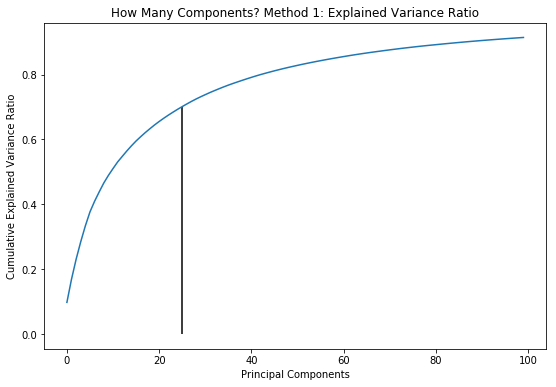

In [5]:
# Find the first 100 principal components
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

# Calculate the cumulative explained variance ratio
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create the plot, including axis labels and title
fig = plt.figure(figsize=(9,6))
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[25],x=25)
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('How Many Components? Method 1: Explained Variance Ratio')

After running the code a few times, I determined the "elbow" we described earlier to occur around the **25th** principal component.

#### b. Plot the first two components. Do you notice any trends? What is this plot showing us?

In [90]:
# Use PCA to find the first two components
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X)

Text(0,0.5,'Second Component')

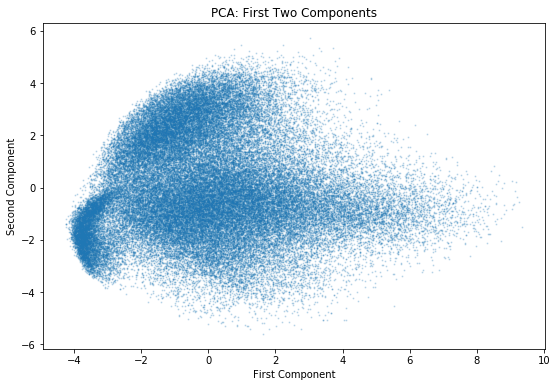

In [92]:
fig = plt.figure(figsize=(9,6))
plt.scatter(X_2dim[:,0], X_2dim[:,1], marker='.', alpha=.2, s = 4)
plt.title('PCA: First Two Components')
plt.xlabel('First Component')
plt.ylabel('Second Component')

We've plotted the two principal components against each other, but there doesn't seem to be a strong trend. Will the same be true when we use t-SNE in later one? Maybe it's not surprising that there's no key trend. What if we were able to visualize the three principal components?

Text(0.5,0.92,'PCA: First Three Components')

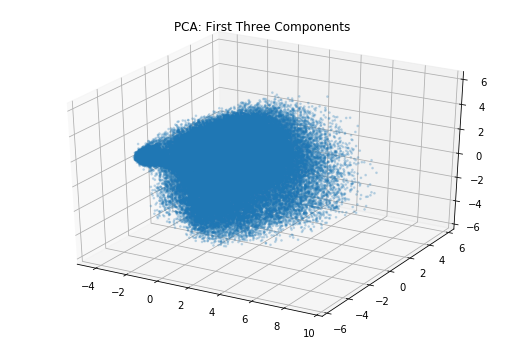

In [93]:
# Three principal components 
pca = PCA(n_components=3)
X_3dim = pca.fit_transform(X)

# Create a 3D plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_3dim[:,0], X_3dim[:,1], X_3dim[:,2], alpha=.2, s = 3)
plt.title('PCA: First Three Components')

There's still not a strong trend. Let's move on! 

#### c. Why would you use PCA? What is it doing? And what are the drawbacks?

PCA, which stands for **principal component analysis**, is a technique used to bring out strong patterns in high-dimensional data. By emphasizing variation, this technique can help simplify data exploration and visualization. [Source](http://setosa.io/ev/principal-component-analysis/)

The principal component are determined by a matrix factorization process called SVD. "The first component is the axis that preserves the most variance, the second principal component is the one orthogonal to the first that preserves the next most amount of variance, the third being orthogonal to the first 2 and preserving the next most amount of variance, etc." [Source](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_12_Dimensionality%20Reduction.ipynb)

PCA works well when you need to compress or remove noise from your dataset. However, it relies on orthogonal transformations and makes the implicit assumption that the data should follow a Gaussian distribution. Also just intuitively, some data is lost since PCA recommends throwing away low variance components, even if those components could play an important role in a supervised learning task. [Source](https://www.quora.com/What-are-some-of-the-limitations-of-principal-component-analysis)

#### d. Plot some of the images, then compress them using PCA and plot again. How does it look?

Text(0.5,1,'101st Image of MNIST dataset')

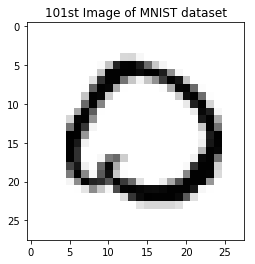

In [95]:
# Original Image
plt.imshow(X[100].reshape((28,28)), cmap='Greys')
plt.title('101st Image of MNIST dataset')

Text(0.5,1,'101st Image of MNIST Dataset: Inversed Transformed')

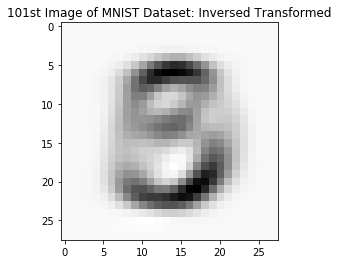

In [97]:
# Two principal components 
pca = PCA(n_components=3)
X_2dim = pca.fit_transform(X)
X_back_to_noraml = pca.inverse_transform(X_2dim)

# Plot the same image that has been compressed and then inversed transformed
plt.imshow(X_back_to_noraml[100].reshape((28,28)), cmap='Greys')
plt.title('101st Image of MNIST Dataset: Inversed Transformed')

After compressing the image and then converting it back, it's blurry! Information was lost in the process.

### 2. Use t-SNE to plot the first two components

In [99]:
# Reduce dimensionality BEFORE feeding to t-sne
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X)

# Use a random sample with 10,000 points
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

# Do t-SNE with two components
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 5.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.610239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.154915
[t-SNE] Error after 1000 iterations: 1.646447


Text(0.5,1,'t-SNE: First Two Components')

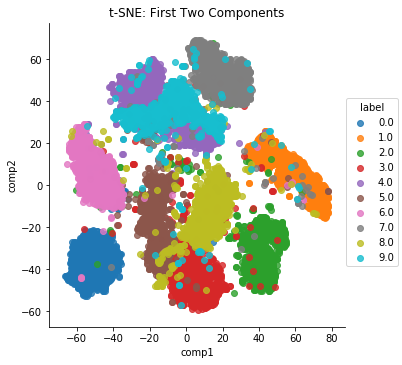

In [100]:
# Create dataframe of results
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

# Create the plot
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE: First Two Components')

#### a. How does this plot differ from your PCA plot?

The trends in the t-SNE plot are _much_ clearer. Since the hue indicates the handwritten number label, we can see the grouping of the handwritten numbers in clearly visible clusters.

#### b. How robust is it to changes in perplexity?

The perplexity hyper-parameter is recommended to be between 5 and 50. We just did it with a value of 50. How will it change with a value on the other end of the recommended spectrum? Let's find out! 

In [102]:
# Use a random sample with 10,000 points
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

# Do t-SNE with two components
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 3.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.891333
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.106186
[t-SNE] Error after 1000 iterations: 1.904029


Text(0.5,1,'t-SNE: First Two Components')

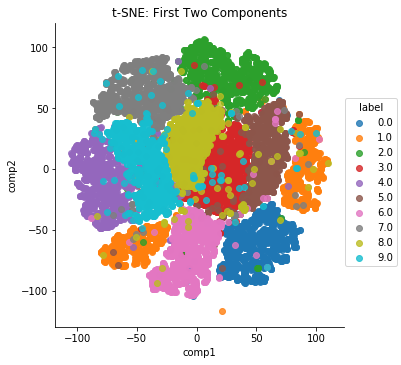

In [103]:
# Create dataframe of results
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

# Create the plot
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE: First Two Components')

Interesting. For one thing, a lower perplexity value resulted in a longer runtime. My MacBook Pro's fans spun up very quickly! This parameter is intended to "balance attention between the local and global aspects of the dataset." [Source](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_12_Dimensionality%20Reduction.ipynb) 

Are these results robust? They don't appear to be. There are still distinct clusters by number label, but they are not in the same position on the plot like they were with a perplexity value of 50. Also, with a perplexity value of 5, the overall shape of the plot is circular, although I'm not sure what meaning to derive from that observation. 

#### c. How robust is it to different learning rate and number of iterations?

Now we're interested in the robustness of our principal component t-SNE plot to changes in other learning parameters: the learning rate and the number of iterations.

Let's try the technique again, but with 1,000 iterations (rather than 10,000) and with a learning rate of 100 (rather than 200). 

In [104]:
# Use a random sample with 1000 points
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 1000

# Do t-SNE with two components
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.384527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.876869
[t-SNE] Error after 1000 iterations: 1.035983


Text(0.5,1,'t-SNE: First Two Components')

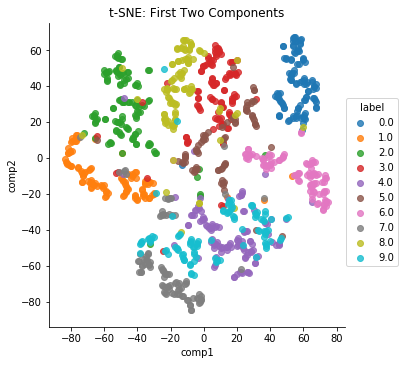

In [105]:
# Create dataframe of results
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

# Create the plot
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE: First Two Components')

Wow! Clearly the number of iterations makes a big difference. The plot above appears much less "filled out" than previous plots we've created. 

Main takeaway: The selection of hyper-parameters matters! It would be important to experiment with different perplexity, learning rate, and iterations values before coming to any final conclusions. 

### 3. K-Means Clustering

What is K-Means Clustering? It is a method to discover clusters or groupings in our data. A good cluster is one where the points within the cluster are similar to each other and different from the points in the other clusters. In k-means clustering we specify the number of clusters through the parameter k. 

#### a. How did you choose k?

K is a hyper-parameter so how do we choose it? Since we haven't been dictated a reasonable value and don't have strong prior knowledge to help guide our choice, we'll rely on the elbow method. We did something very similar above when determining how many components to use in PCA.

In [107]:
# Scale the data
X_scaled = preprocessing.scale(X)

# Take sample of the data
X_scaled = shuffle(X_scaled)[0:3000]

# Two first components
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X_scaled)

# Create Pandas DataFrame
df = pd.DataFrame({'1st':X_2dim[:,0], '2nd':X_2dim[:,1]})

Text(0.5,1,'Determining an Appropriate Value of K: The Elbow Method')

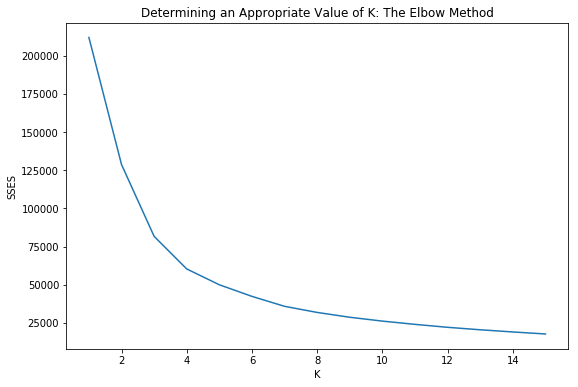

In [109]:
# Calculate SSES for values of K from 1 to 16
sses = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k, n_init=25, n_jobs=-1)
    kmeans.fit(df[['1st', '2nd']])
    sses.append(kmeans.inertia_)
    
# Create plot, including title and axis lables
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,16), sses)    
plt.ylabel('SSES')
plt.xlabel('K')
plt.title('Determining an Appropriate Value of K: The Elbow Method')

I'd say the elbow falls somewhere between 5 and 6 clusters. Let's proceed by fitting a model with 5 clusters.

#### b. How did you evaluate your clustering?

Now that we have a good idea of an approiate value for k and have fit a clustering model, how do we know if it's any good? One possibility is the silhouette coefficient, which is "the mean distance between a sample and all other points in the nearest cluster subtracted by the mean distance between a sample and all other points in the same class." [Source](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_13_Clustering.ipynb)

With this evaluation metric, which ranges from -1 to 1, the higher the better. One way to think about it is that a higher score means the clusters are well separated from each other and dense within a cluster.

In [112]:
# Evaluate clustering via the Silhouette Coefficient
kmeans_model = KMeans(n_clusters=5, n_init=50, n_jobs=-1).fit(df[['1st', '2nd']])
labels = kmeans_model.labels_
silhouette_score(df[['1st', '2nd']], labels, metric='euclidean')

0.35341690071499443

Here we calculate a silhouette Coefficient of .353, so our model is doing okay, but we might be able to do better. Let's next visualize these clusters using t-sne.

#### c. Visualize your clusters using t-sne

In [113]:
# Do t-SNE with two components
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X_scaled)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.057s...
[t-SNE] Computed neighbors for 3000 samples in 10.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 4.083494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.494255
[t-SNE] Error after 1000 iterations: 1.375583


Text(0.5,1,'t-SNE: First Two Components with K-Means Clustering Labels')

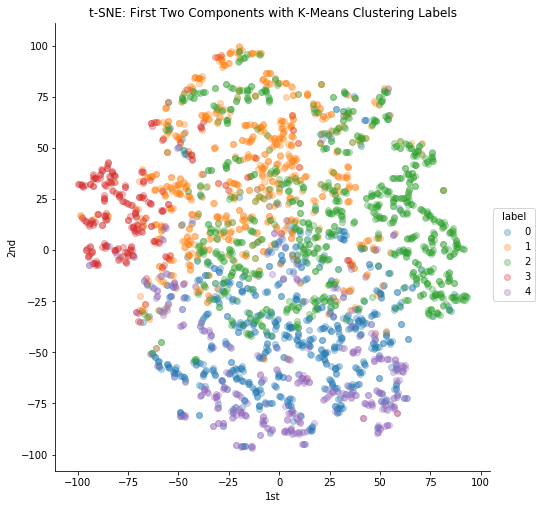

In [114]:
# Create dataframe of results
df_tsne = pd.DataFrame(tsne_results, columns=['1st', '2nd'])
df_tsne['label'] = labels

# Create the plot
sns.lmplot(x='1st', y='2nd', data=df_tsne, hue='label', fit_reg=False, scatter_kws={'alpha':0.3}, size=7)
plt.title('t-SNE: First Two Components with K-Means Clustering Labels')

Very cool! Here we can see the distribution of the labels. There's a lot of overlap between the number one and the number four, while the zeros seem to be more tightly clustered.

#### d. Did you scale your data?

Yes! I scaled the data using the function scale() from preprocessing in sklearn.

#### e. How robust is your clustering?

Let's find out! I'll run the model again with 5 clusters but this time with 5 iterations, rather than 50.

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.083s...
[t-SNE] Computed neighbors for 3000 samples in 11.878s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 4.083494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.675446
[t-SNE] Error after 1000 iterations: 1.381452


Text(0.5,1,'t-SNE: First Two Components with K-Means Clustering Labels (5 Iterations)')

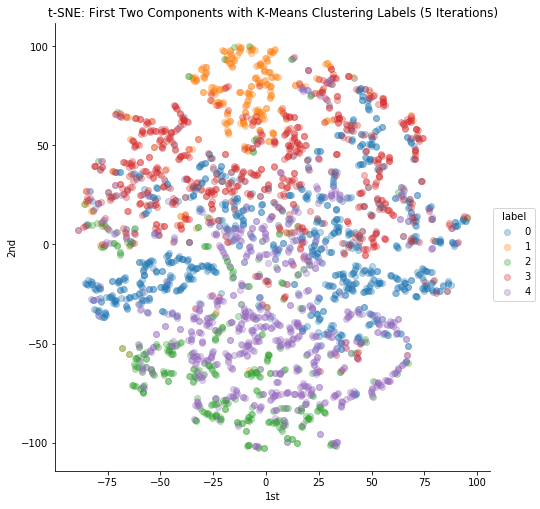

In [115]:
# Evaluate clustering via the Silhouette Coefficient
kmeans_model = KMeans(n_clusters=5, n_init=5, n_jobs=-1).fit(df[['1st', '2nd']])
labels = kmeans_model.labels_

# Do t-SNE with two components
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X_scaled)

# Create dataframe of results
df_tsne = pd.DataFrame(tsne_results, columns=['1st', '2nd'])
df_tsne['label'] = labels

# Create the plot
sns.lmplot(x='1st', y='2nd', data=df_tsne, hue='label', fit_reg=False, scatter_kws={'alpha':0.3}, size=7)
plt.title('t-SNE: First Two Components with K-Means Clustering Labels (5 Iterations)')

Hmm, this plot actually looks similar to the plot when we created k-means clusters with 50 iterations, but it looks as if it were flipped along the y-axis, and with different colors representing different labels. That being said, the general shape of the two components plotted against each other is still circular, with a great deal of overlap between the labels.

### 4. Perform hierarchical clustering

On to the next challenge! Here we'll try another kind of clustering.

#### a. Plot your dendrogram

On account of the plot looking exceedingly hideous when including all 70,000 data points and the potential for absurdly long run-times, below I create a series of dendrograms using a shuffled sample of the data.

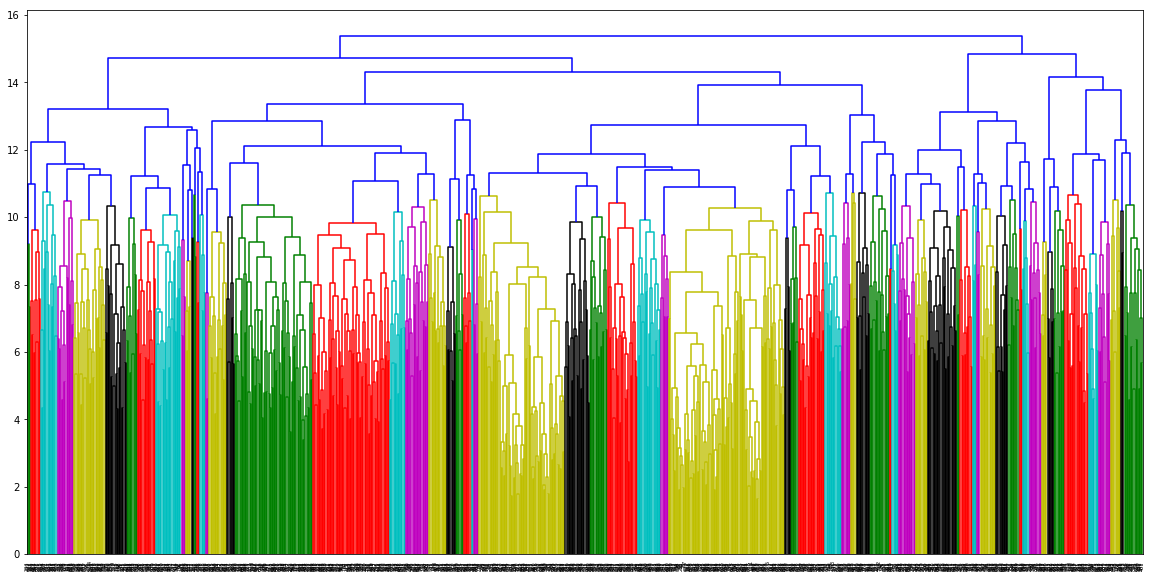

In [13]:
X_shuffled = shuffle(X)
Z = linkage(X_shuffled[0:1000], 'complete')
plt.figure(figsize=(20, 10))
_ = dendrogram(Z)

#### b. How many clusters seem reasonable based off your graph?

We can determine an appropriate number of clusters by drawing a horizontal line at the y-axis, where the number of lines the horizontal line crosses represents the number of clusters. In this case, it's not totally clear where the right selection is, but we can make an educated judgement. Drawing the horizontal line around y = 14 yields about 8 clusters.

#### c. How does your dendrogram change with different linkage methods?

There are several linkage methods, some of which are not currently implemented in sklearn. Different methods exists because there are different way to measure distance between clusters than are made up of multiple points. In the plot above we used the 'complete' method, which uses the **maximum** distance between points. 

Let's try two additional methods below and observe what changes, if only, occur in the dendrogram plot. The 'ward' method "merges the two clusters which minimize the total within-cluster variance after merging" and the 'average' method, you guessed it, uses the **average** distance between points. [Source](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_13_Clustering.ipynb)

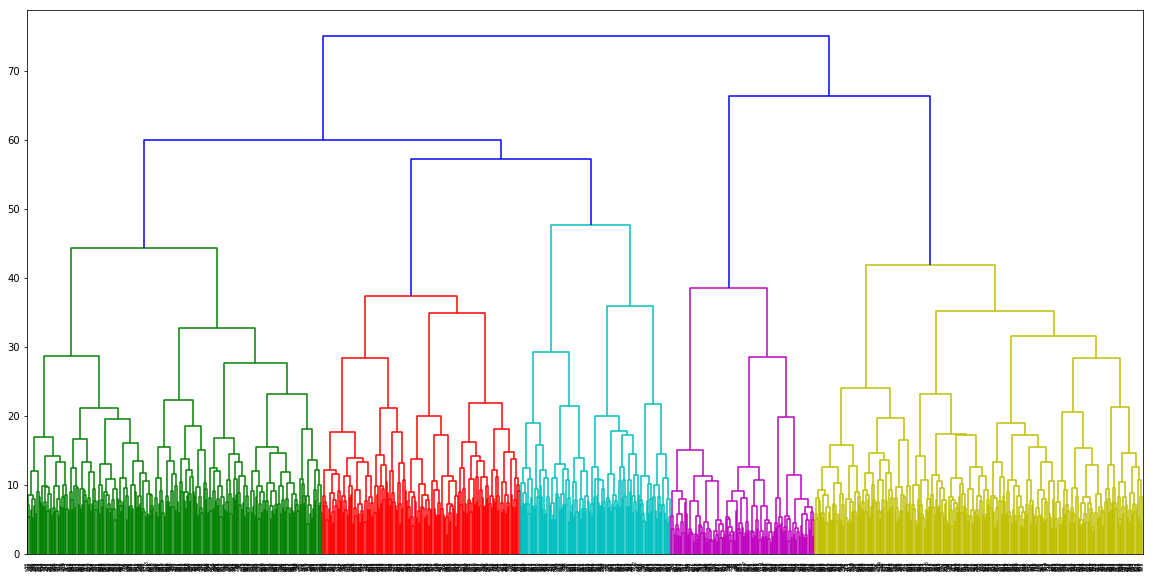

In [14]:
# Dendrogram using the 'ward' method
Z = linkage(X_shuffled[0:1000], 'ward')
plt.figure(figsize=(20, 10))
_ = dendrogram(Z)

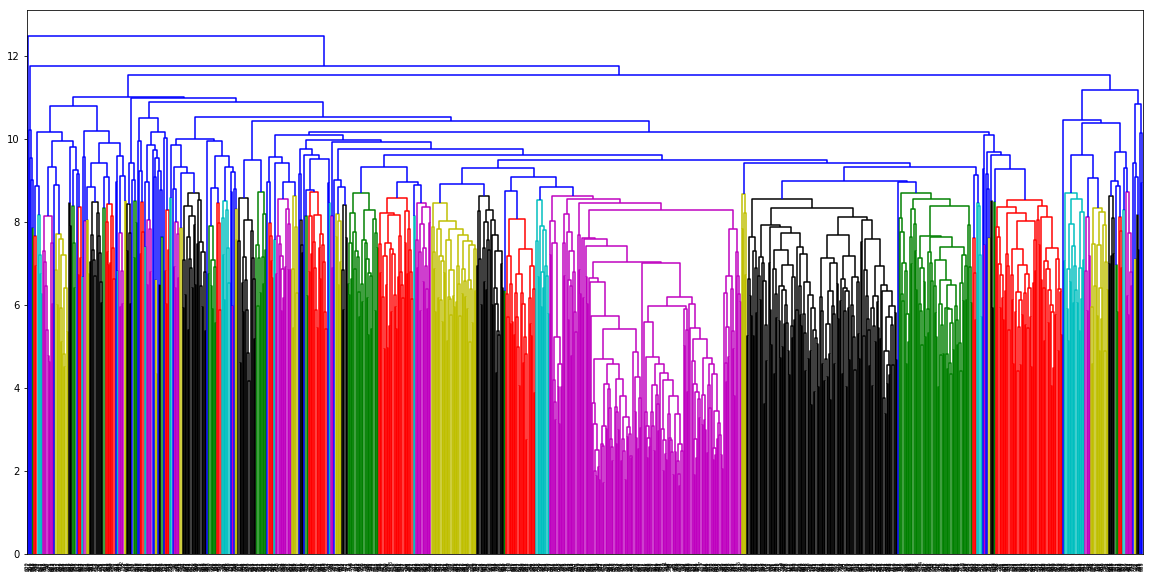

In [88]:
# Dendrogram using the 'average' method
Z = linkage(X_shuffled[0:1000], 'average')
plt.figure(figsize=(20, 10))
_ = dendrogram(Z)

Interesting, there are some pretty significant differences in the dendrograms across methods. For example, the 'ward' method created **much** more clear-cut clusters compared to the 'average' method. The takeaway for me then is that any good analysis would include several methods in order to gain a more complete understanding of the data.

That's all folks! Thanks for joining me in this adventure in dimensionality reduction and clustering. Until next time!
